In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

from models import SimpleModel, ConcreteModel, ConcreteDropout, normal_nll
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from data import FakeData

torch.manual_seed(2809)
np.random.seed(2809)
torch.cuda.manual_seed(2809)
%load_ext autoreload
%autoreload 2

### Utility functions

In [2]:
def generate_data(N, X_dim, Y_dim):
    """
    Function to generate data
    """
    sigma = 0.7  # ground truth
    X = torch.randn(N, X_dim)
    w = torch.ones((X_dim, Y_dim))*2.0
    b = 8.0
    Y = torch.mm(X, w) + b + sigma*torch.randn(N, Y_dim)
    return X, Y

In [3]:
def print_weights(model):
    print(model.fc1.weight.data)
    print(model.fc2.weight.data)
    print(model.fc1.bias.data)
    print(model.fc2.bias.data)

def save_checkpoint(state, filename='checkpoint.pth'):
    torch.save(state, filename)
    
def evaluate_loss(pred, true, log_var=None):
    if log_var is None:
        return nn.MSELoss()(pred, true)
    else:
        return normal_nll(pred, true, log_var)

def generate_data(N, X_dim, Y_dim):
    """
    Function to generate data
    """
    sigma = 0.3  # ground truth
    X = torch.randn(N, X_dim)
    w = torch.ones((X_dim, Y_dim))*2.0
    b = 8.0
    Y = torch.mm(X, w) + b + sigma*torch.randn(N, Y_dim)
    return X, Y

### Global config (model type, CPU/GPU)

In [4]:
checkpoint_path = 'checkpoint.pth'
batch_size = 25
n_hidden = 3
n_train = 1000
n_val = 100
n_data = n_train + n_val
X_dim = 4
Y_dim = 2

# For ConcreteModel
l = 1e-4 # length scale
wr = l**2. / n_train
dr = 2. / n_train

In [5]:
# Generate fake data
X, Y = generate_data(n_data, X_dim, Y_dim)
X_train, Y_train = X[:n_train], Y[:n_train]
X_val, Y_val = X[n_train:], Y[n_train:]

In [6]:
epoch = 0
device = 'cuda'
simple_model = False

if device=='cuda':
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else: # cpu
    torch.set_default_tensor_type('torch.FloatTensor')
print("device: ", device)

if simple_model:
    model = SimpleModel(X_dim, n_hidden, Y_dim)
    model_resume = SimpleModel(X_dim, n_hidden, Y_dim).to(device)
else: # ConcreteModel
    model = ConcreteModel(X_dim, n_hidden, Y_dim, wr, dr).to(device)
    model_resume = ConcreteModel(X_dim, n_hidden, Y_dim, wr, dr).to(device)

optimizer = optim.Adam(model.parameters(), 
                      betas=(0.9, 0.999), eps=1e-08, amsgrad=True)
optimizer_resume = optim.Adam(model_resume.parameters(), 
                             betas=(0.9, 0.999), eps=1e-08, amsgrad=True)

device:  cuda


In [7]:
# Create dataloader
data = FakeData(X, Y)
kwargs = {'num_workers': 1, 'pin_memory': True} if device=='cuda' else {}
train_sampler = SubsetRandomSampler(np.arange(n_train))
train_loader = DataLoader(data, batch_size=batch_size, sampler=train_sampler, **kwargs)

In [8]:
for x_, y_ in train_loader:
    print(x_.shape, y_.shape)
    print(x_.shape[0])
    #print(x_)
    #print(y_)
    break

torch.Size([25, 4]) torch.Size([25, 2])
25


In [9]:
# Train for one epoch
losses = []
while epoch < 200:
    loss_val = 0
    for X_, Y_ in train_loader:
        
        X_batch = Variable(torch.FloatTensor(X_)).to(device)
        Y_batch = Variable(torch.FloatTensor(Y_)).to(device)
        pred, log_var, reg = model(X_batch)
        optimizer.zero_grad()
        loss = evaluate_loss(pred, Y_batch, log_var) + reg
        loss.backward()
        optimizer.step()
        loss_val += loss.item()*X_batch.shape[0]/n_train
    losses.append(loss_val)
    epoch += 1

save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer' : optimizer.state_dict(),
            }, checkpoint_path)
#print_weights(model)
#optimizer.state_dict()

In [10]:
# Resume training
print("cuda: %s" %next(model.parameters()).is_cuda)
print("=> loading checkpoint '{}'".format(checkpoint_path))
checkpoint = torch.load(checkpoint_path)
epoch = checkpoint['epoch']
model_resume.load_state_dict(checkpoint['state_dict'])
optimizer_resume.load_state_dict(checkpoint['optimizer'])
#print_weights(model_resume)
#optimizer_resume.state_dict()

cuda: True
=> loading checkpoint 'checkpoint.pth'


In [11]:
# Train model for 100 more epochs
while epoch < 300:
    loss_val = 0
    for X_, Y_ in train_loader:
        optimizer.zero_grad()
        X_batch = Variable(torch.FloatTensor(X_)).to(device)
        Y_batch = Variable(torch.FloatTensor(Y_)).to(device)
        pred, log_var, reg = model(X_batch)
        loss = evaluate_loss(pred, Y_batch, log_var) + reg
        loss.backward()
        optimizer.step()
        loss_val += loss.item()*X_batch.shape[0]/n_train
    losses.append(loss_val)
    epoch += 1

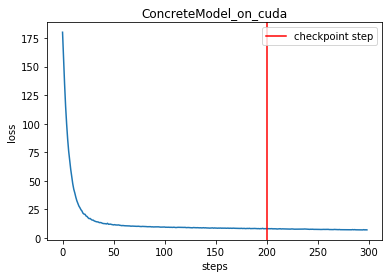

In [12]:
losses_arr = np.array(losses)
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('steps')
plt.axvline(x=200, color='r', label='checkpoint step')
plt.title('%s_on_%s' %(model.__class__.__name__, device))
plt.legend()
#plt.savefig('%s_on_%s.png' %(model.__class__.__name__, device))